In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
import cv2 as cv
from time import time

# TODO 
# Estimate_horagraphyDLT22, transform22, translation2D 
# Las ultimas 2 creo que estan en el repo de graficas de Denis

In [3]:
MIN_MATCH_COUNT = 3



sift = cv.SIFT_create()

In [4]:
path = 'imgs/cuar/'

img_ext = '.jpg'
imgnumber = 3

im = [] 

for i in range(1,imgnumber+1):
    full_name = path + str(i) + img_ext
    # resie the image to 50% of its size
    img = cv.imread(full_name, cv.IMREAD_GRAYSCALE)
    #img = cv.resize(img, (0,0), fx=0.5, fy=0.5)
    im.append(img)



In [5]:
shapes = np.zeros((imgnumber,2)).astype(int)

for i in range(imgnumber):
    shapes[i,:] = im[i].shape[:2]

print(shapes)

[[2992 2992]
 [2992 2992]
 [2992 2992]]


In [6]:
kps =[] 
des = []

for i in range(imgnumber):
    kp, ds = sift.detectAndCompute(im[i],None)
    kps.append(kp)
    des.append(ds)
    print('Image ' + str(i) + ' has ' + str(len(kp)) + ' keypoints')

Image 0 has 36924 keypoints
Image 1 has 41683 keypoints
Image 2 has 25954 keypoints


In [7]:
bf = cv.BFMatcher()

matches = []
goods = []

for i in range(imgnumber-1):
    matches.append(bf.knnMatch(des[i],des[i+1],k=2))

    print("Total matches from image {} to image {} are {}".format(i,i+1,len(matches[i])))

    good = []

    for m,n in matches[i]:
        if m.distance < 0.75*n.distance:
            good.append(m)

    goods.append(good)
    print("Good matches from image {} to image {} are {}".format(i,i+1,len(good)))

Total matches from image 0 to image 1 are 36924
Good matches from image 0 to image 1 are 1508
Total matches from image 1 to image 2 are 41683
Good matches from image 1 to image 2 are 2469


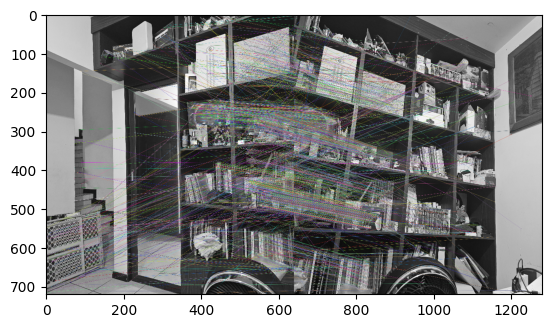

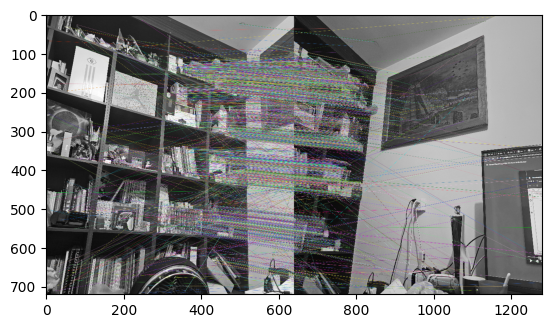

In [9]:
import matplotlib.pyplot as plt

for i in range(1, imgnumber):
    if len(goods[i-1]) > 0:
        draw = cv.drawMatches(im[i-1], kps[i-1], im[i], kps[i], goods[i-1], None, flags=2)
        draw = cv.resize(draw, (1280, 720))
        plt.imshow(cv.cvtColor(draw, cv.COLOR_BGR2RGB))
        plt.show()
    else:
        print(f"No good matches between image {i} and {i-1}.")


## Estimate Homographies

In [10]:

def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match.queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match.trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv.findHomography(
        SecImage_pts, BaseImage_pts, cv.RANSAC, 4.0)

    return HomographyMatrix, Status


In [11]:
H = [np.eye(3)]  

for i in range(1, imgnumber):
    # Verificar si hay suficientes coincidencias
    if len(goods[i - 1]) >= MIN_MATCH_COUNT:
        # Encontrar la homografía entre las imágenes i e i-1

        H_i, status = FindHomography(goods[i - 1], kps[i - 1], kps[i])
        H.append(H_i)
        print(f"Homography matrix between image {i} and {i-1} is:\n{H_i}")

Homography matrix between image 1 and 0 is:
[[ 1.22934511e-01  2.26250169e-01  1.51042843e+03]
 [-5.79423397e-01  8.68575032e-01  2.02579212e+02]
 [-2.92773290e-04  3.24972869e-05  1.00000000e+00]]
Homography matrix between image 2 and 1 is:
[[ 4.22498442e-01  1.27915516e-01  1.47822458e+03]
 [-3.78585240e-01  8.52691117e-01  1.95302367e+02]
 [-1.84141596e-04  1.98817018e-06  1.00000000e+00]]


In [12]:
for i in range(0,imgnumber):
    print(H[i])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.22934511e-01  2.26250169e-01  1.51042843e+03]
 [-5.79423397e-01  8.68575032e-01  2.02579212e+02]
 [-2.92773290e-04  3.24972869e-05  1.00000000e+00]]
[[ 4.22498442e-01  1.27915516e-01  1.47822458e+03]
 [-3.78585240e-01  8.52691117e-01  1.95302367e+02]
 [-1.84141596e-04  1.98817018e-06  1.00000000e+00]]


In [13]:
# # change panorama tro based at central image
# center = imgnumber//2
# if (center > 0):
#     for i in range(imgnumber):
#         H[i] = np.linalg.inv(H[center]) @ H[i]
    
#     H[center] = np.eye(3)

In [14]:
# print('Homographies adjusted to central image')
# for i in range(imgnumber):
#     print(H[i])

Homographies adjusted to central image
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.22934511e-01  2.26250169e-01  1.51042843e+03]
 [-5.79423397e-01  8.68575032e-01  2.02579212e+02]
 [-2.92773290e-04  3.24972869e-05  1.00000000e+00]]
[[ 4.22498442e-01  1.27915516e-01  1.47822458e+03]
 [-3.78585240e-01  8.52691117e-01  1.95302367e+02]
 [-1.84141596e-04  1.98817018e-06  1.00000000e+00]]


In [15]:
import numpy as np
import cv2 as cv

def update_homography(H, new_H):
    """ Actualiza la matriz de homografía acumulada con una nueva transformación. """
    return np.dot(new_H, H)

def calculate_final_frame_size(homographies, image_shapes):
    """ Calcula el tamaño del marco final basado en todas las transformaciones y tamaños de imagen. """
    min_x, min_y = 0, 0
    max_x, max_y = 0, 0
    
    # Iniciar con la primera imagen, que está sin transformar.
    (h, w) = image_shapes[0]
    corners = np.float32([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
    
    # Evaluar los límites de las esquinas de la primera imagen.
    for i in range(len(homographies)):
        transformed_corners = np.dot(homographies[i], corners)
        transformed_corners /= transformed_corners[2]  # Normalizar
        
        x = transformed_corners[0, :]
        y = transformed_corners[1, :]
        
        min_x = min(min_x, min(x))
        max_x = max(max_x, max(x))
        min_y = min(min_y, min(y))
        max_y = max(max_y, max(y))
    
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height)

# Lista de matrices de homografía y tamaños de imagen
homographies = [np.eye(3)]  # Inicializar con la matriz identidad para la primera imagen

# Supongamos que tienes una lista `H` que contiene las homografías entre pares consecutivos de imágenes
for H_pair in H[1:]:
    homographies.append(update_homography(homographies[-1], H_pair))

# Supongamos que `shapes` contiene los tamaños (altura, anchura) de cada imagen
image_shapes = shapes

# Calcular el tamaño del marco final
final_frame_size = calculate_final_frame_size(homographies, image_shapes)
print("El tamaño del marco final es:", final_frame_size)


El tamaño del marco final es: (21389, 21205)


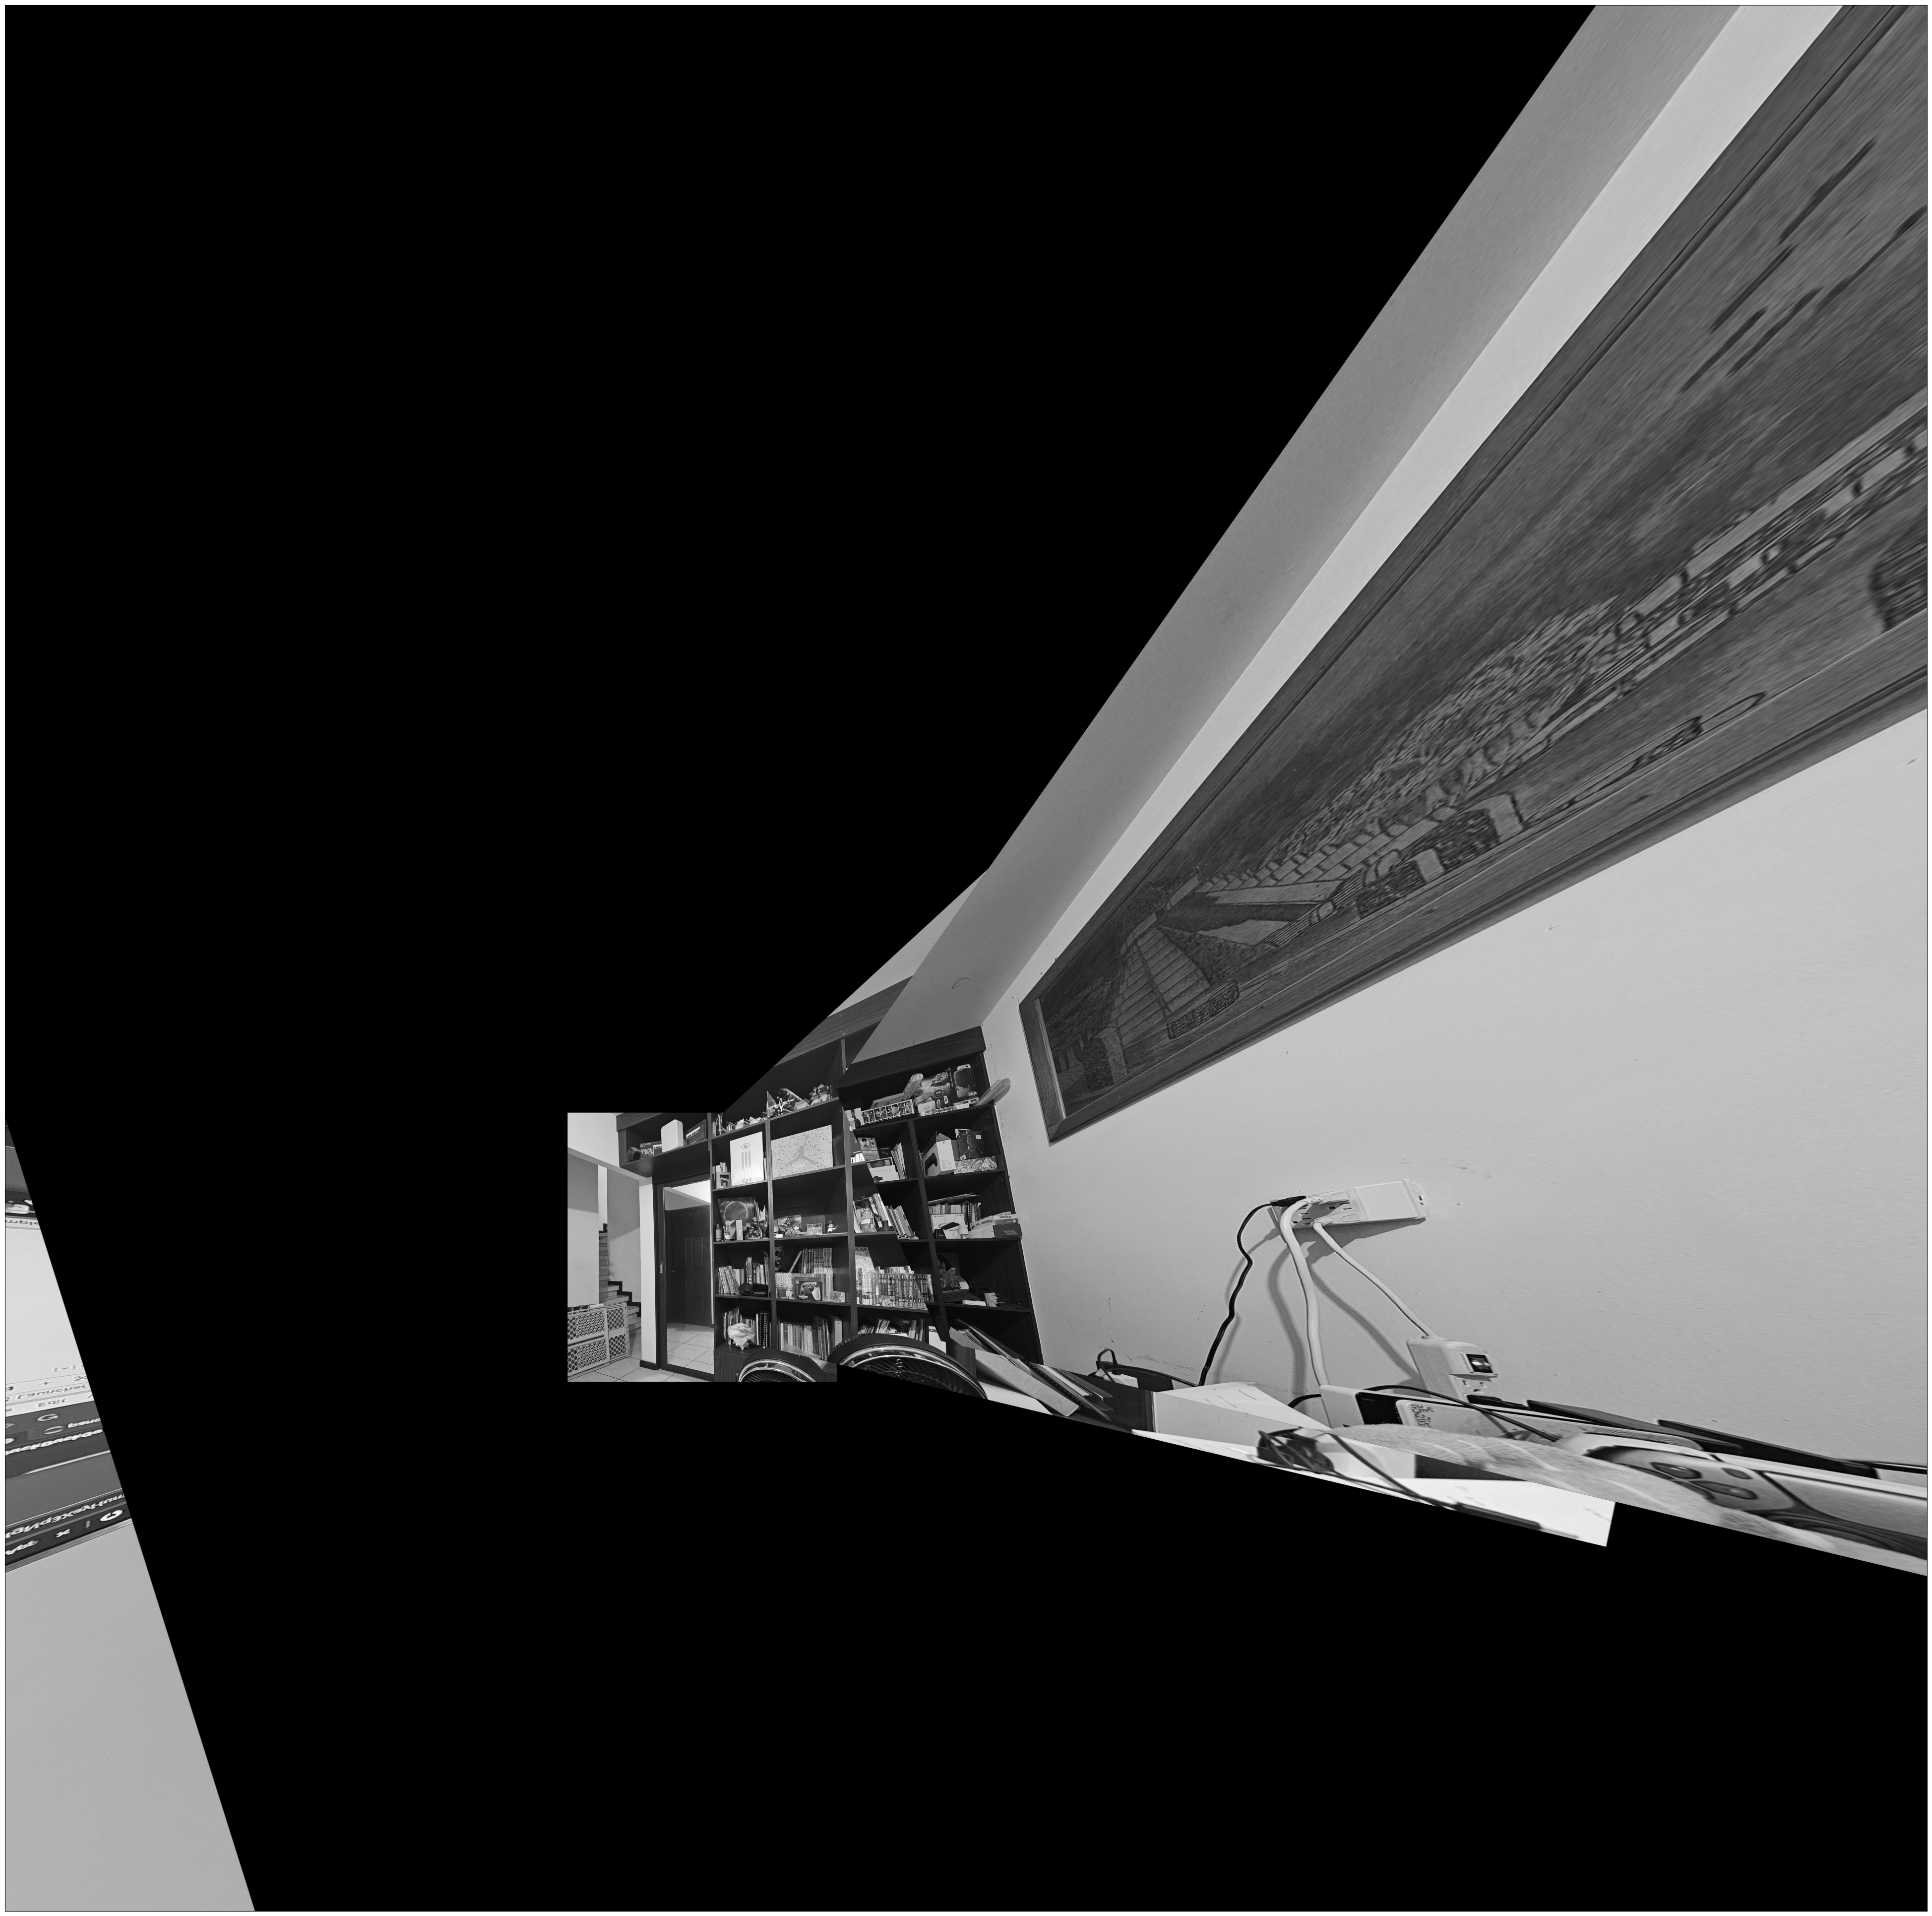

In [17]:
import numpy as np
import cv2 as cv

def calculate_correction(homographies, image_shapes):
    """ Calcula el tamaño del marco final y las correcciones necesarias basadas en todas las transformaciones. """
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    
    # Transformar las esquinas de cada imagen y encontrar los límites mínimos y máximos
    for i, H in enumerate(homographies):
        h, w = image_shapes[i]
        corners = np.array([
            [0, 0, 1],
            [w - 1, 0, 1],
            [w - 1, h - 1, 1],
            [0, h - 1, 1]
        ]).T
        transformed_corners = np.dot(H, corners)
        transformed_corners /= transformed_corners[2, :]  # Normalización
        
        min_x = min(min_x, np.min(transformed_corners[0, :]))
        max_x = max(max_x, np.max(transformed_corners[0, :]))
        min_y = min(min_y, np.min(transformed_corners[1, :]))
        max_y = max(max_y, np.max(transformed_corners[1, :]))
    
    # Corregir las coordenadas negativas
    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    corrected_homographies = [np.dot(translation, H) for H in homographies]
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height), corrected_homographies

def stitch_images(images, homographies, frame_size):
    """ Coloca todas las imágenes en un marco único usando las homografías corregidas. """
    stitched_image = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)
    
    for i, image in enumerate(images):
        # Transforma la imagen actual a su lugar en el marco final
        transformed_image = cv.warpPerspective(image, homographies[i], (frame_size[0], frame_size[1]))
        # Crear máscara donde la imagen tiene valores no nulos
        mask = (transformed_image > 0)[..., 0]
        stitched_image[mask] = transformed_image[mask]  # Colocar imagen en marco
        
    return stitched_image

# Suponemos que `im` es la lista de imágenes y `shapes` contiene las dimensiones de cada imagen
image_shapes = [(img.shape[0], img.shape[1]) for img in im]
final_frame_size, corrected_homographies = calculate_correction(homographies, image_shapes)

# Convertir imágenes a color si no lo están
color_images = [cv.cvtColor(img, cv.COLOR_GRAY2BGR) if len(img.shape) == 2 else img for img in im]

# Obtener la imagen panorámica final
panoramic_image = stitch_images(color_images, corrected_homographies, final_frame_size)
plt.figure(figsize=(50,50))
plt.imshow(panoramic_image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
